Epoch [100/2000], Loss: 0.005948604550212622
Epoch [200/2000], Loss: 0.003982902970165014
Epoch [300/2000], Loss: 0.003081744536757469
Epoch [400/2000], Loss: 0.002646396402269602
Epoch [500/2000], Loss: 0.002384301507845521
Epoch [600/2000], Loss: 0.002153153996914625
Epoch [700/2000], Loss: 0.002095170086249709
Epoch [800/2000], Loss: 0.0019603893160820007
Epoch [900/2000], Loss: 0.001870849635452032
Epoch [1000/2000], Loss: 0.0018175458535552025
Epoch [1100/2000], Loss: 0.0017041534883901477
Epoch [1200/2000], Loss: 0.0016276920214295387
Epoch [1300/2000], Loss: 0.0016201044199988246
Epoch [1400/2000], Loss: 0.0016251469496637583
Epoch [1500/2000], Loss: 0.0015068913344293833
Epoch [1600/2000], Loss: 0.0014466120628640056
Epoch [1700/2000], Loss: 0.0014213959220796824
Epoch [1800/2000], Loss: 0.0014299864415079355
Epoch [1900/2000], Loss: 0.0013533621095120907
Epoch [2000/2000], Loss: 0.0013186892028898
Average Mean Absolute Error (MAE): 26.05971983364079
Average Root Mean Squared E

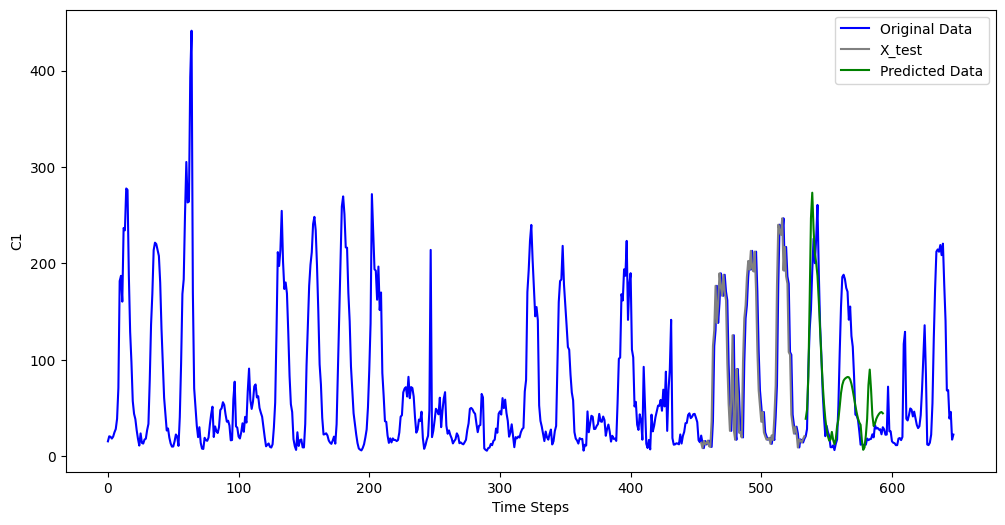

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

def create_sequences(data, day_of_week, hour, seq_length):
    sequences = []
    labels = []

    for i in range(len(data) - seq_length):
        seq = torch.cat([data[i:i+seq_length], day_of_week[i:i+seq_length], hour[i:i+seq_length]], dim=1)
        label = data[i+seq_length:i+seq_length+1]
        sequences.append(seq)
        labels.append(label)

    return torch.stack(sequences), torch.stack(labels)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


df = pd.read_csv("data/reduced/June2022_reduced.csv")
df = df[df['Grid_ID'] == 16]  # Select a single grid
df["Datetime"] = pd.to_datetime(df["Datetime"])
df.set_index("Datetime", inplace=True)

# Resample the "C1" column for each hour and calculate the mean values
df_hourly_mean = df["C1"].resample("H").mean().interpolate()    

# Create a new DataFrame with the mean values, Grid_ID, and Datetime
resampled_df = pd.DataFrame({
    "Grid_ID": df["Grid_ID"].resample("H").first(),
    "Datetime": df_hourly_mean.index,
    "C1": df_hourly_mean
})

# Add a new columns, might be useful later
resampled_df["DayOfWeek"] = resampled_df["Datetime"].dt.dayofweek
resampled_df["Hour"] = resampled_df["Datetime"].dt.hour
day_of_week_values = resampled_df["DayOfWeek"].values
day_of_week_tensor = torch.tensor(day_of_week_values, dtype=torch.float32).reshape(-1, 1)
hour_values = resampled_df["Hour"].values
hour_tensor = torch.tensor(hour_values, dtype=torch.float32).reshape(-1, 1)


target_col = 'C1'
target = resampled_df[target_col].values.reshape(-1, 1)
scaler = MinMaxScaler()
target_scaled = scaler.fit_transform(target)
target_tensor = torch.tensor(target_scaled, dtype=torch.float32)


# Define sequence length and create sequences
sequence_length = 80
sequences, labels = create_sequences(target_tensor, day_of_week_tensor, hour_tensor, sequence_length)
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42, shuffle=False)


# Initialize the model
input_size = 3 
hidden_size = 30
output_size = 1  # Predicting one value (C1)
model = LSTMModel(input_size, hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 2000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)

    loss = criterion(outputs.squeeze(), y_train.squeeze()) 
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Making predictions
model.eval()
future = 60
num_test_sequences = len(X_test) - future
test_sequences = X_test[:num_test_sequences, :, :]
predicted_sequences = []
with torch.no_grad():
    for test_seq in test_sequences:
        base_seq = test_seq.unsqueeze(0).clone()
        predicted_seq = []
        next_day = base_seq[:, -1:, 1]
        for i in range(future):
            pred = model(base_seq)
            predicted_seq.append(pred.item())

            next_hour = (base_seq[:, -1:, 2] + 1) % 24
            if(next_hour == 0):
                next_day = (base_seq[:, -1:, 1] + 1) % 7
        
            next_value = torch.cat([pred.unsqueeze(2), next_day.unsqueeze(2), next_hour.unsqueeze(2)], dim=2)  # Include hour tensor
            base_seq = torch.cat([base_seq[:, 1:, :], next_value], dim=1)
        # Inverse transform the values
        predicted_seq = np.array(predicted_seq).reshape(-1, 1)
        predicted_seq = scaler.inverse_transform(predicted_seq)
        predicted_sequences.append(predicted_seq)


y_test = scaler.inverse_transform(y_test.squeeze().reshape(-1, 1))
mae_list = []
rmse_list = []

for i in range(num_test_sequences):
    y_t = y_test[i:i+future]
    predicted_seq = predicted_sequences[i]
    mae = mean_absolute_error(y_t, predicted_seq)
    rmse = np.sqrt(mean_squared_error(y_t, predicted_seq))

    mae_list.append(mae)
    rmse_list.append(rmse)

average_mae = np.mean(mae_list)
average_rmse = np.mean(rmse_list)

print(f"Average Mean Absolute Error (MAE): {average_mae}")
print(f"Average Root Mean Squared Error (RMSE): {average_rmse}")

# Plot the results
test_start = len(target) - len(y_test)
seq_used_pred = scaler.inverse_transform(test_sequences[1, :,0].squeeze().reshape(-1, 1).clone())

plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(target)), target, label='Original Data', color='blue')
plt.plot(np.arange(test_start - len(seq_used_pred), test_start),  np.array(seq_used_pred).reshape(-1, 1), label='X_test', color='gray')
plt.plot(np.arange(test_start, test_start + future), predicted_sequences[0], label='Predicted Data', color='green')

plt.xlabel('Time Steps')
plt.ylabel(target_col)
plt.legend()
plt.show()

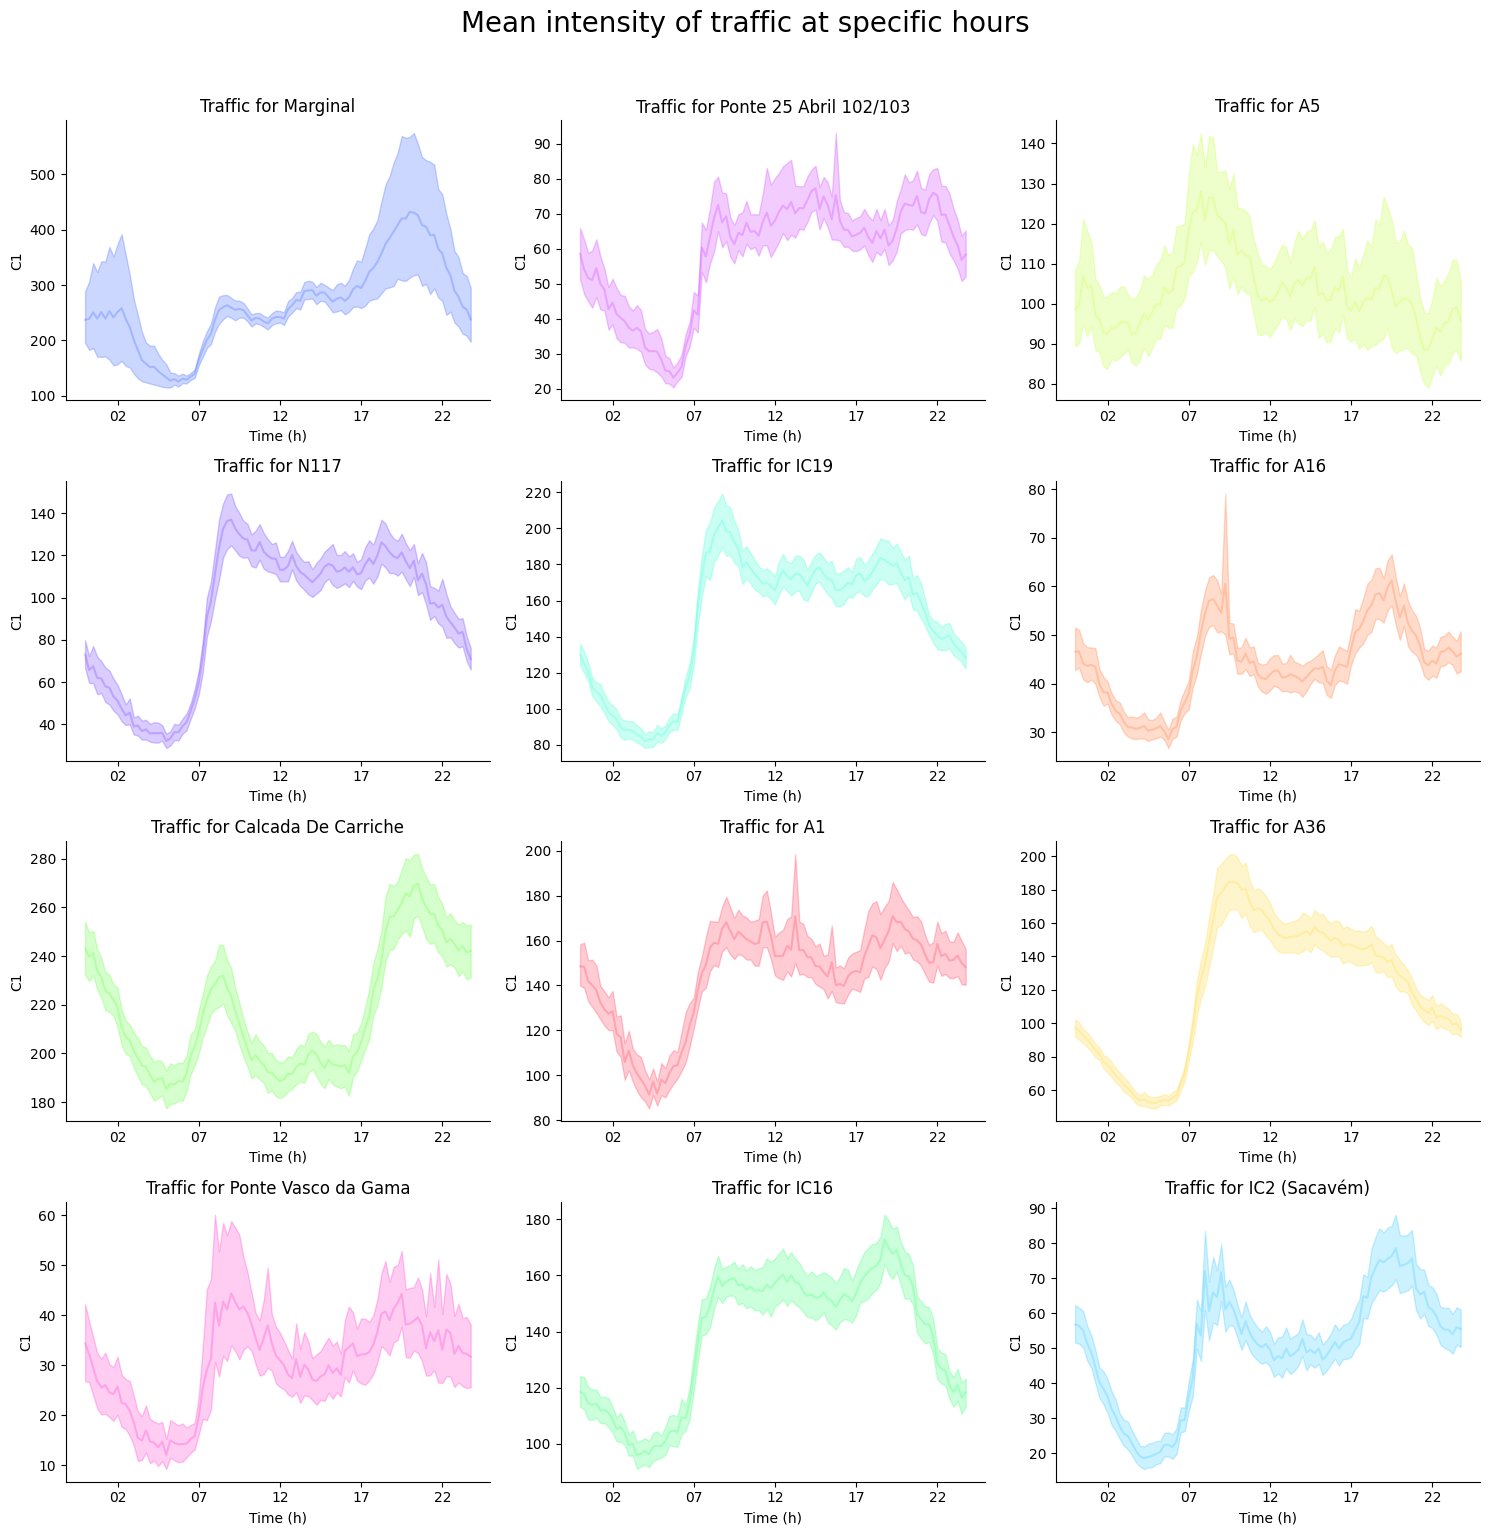

In [1]:
import cml
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib import colormaps as cm
from shapely import wkt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates



vodafone_data = cml.VodafoneData()
main_roads_df = vodafone_data.read('data/reduced/jj') # Read the data from the folder (All Vodafone data)
vodafone_data.preprocess(main_roads_df)

columns = ['Grid_ID', 'Datetime', 'C1', 'C2', 'C11', 'E1', 'E7', 'E8', 'E9']
main_roads_df = main_roads_df[columns]

grids_df = pd.read_csv('data/wktComplete.csv', encoding='latin-1', index_col='grelha_id')
grids_df['geometry'] = grids_df.wkt.apply(wkt.loads)
grids_geo = gpd.GeoDataFrame(grids_df) 
grids_geo.sort_index(inplace=True)
grids_geo.set_crs(epsg=4326, inplace=True)
grids_geo.to_crs(epsg=3857, inplace=True)

entrance_roads_girds_id = [value for values in cml.street_names.values() for value in values]
entrance_roads_df = main_roads_df[main_roads_df.Grid_ID.isin(entrance_roads_girds_id)].copy()
entrance_roads_df.describe()


def assign_street_name(grid_id):
    for street, grid_ids in cml.street_names.items():
        if grid_id in grid_ids:
            return street
    return None

def cmap_to_dict(cmap, categories):
    return {category: cmap(i) for category, i in zip(categories, np.linspace(0, 1, len(categories)))}

grids_geo['street_name'] = grids_geo.index.map(assign_street_name)
grids_geo['street_name'] = grids_geo['street_name'].astype('category')
main_streets_grids_geo = grids_geo[grids_geo.street_name.notna()]
streets_cmap_name = 'gist_rainbow'
streets_cmap = cm.get_cmap(streets_cmap_name)
streets_cmap_dict = cmap_to_dict(streets_cmap, main_streets_grids_geo.street_name.cat.categories)

entrance_roads_df['street_name'] = entrance_roads_df.Grid_ID.map(assign_street_name)
entrance_roads_df['hour'] = entrance_roads_df.Datetime.dt.hour
entrance_roads_df['minute'] = entrance_roads_df.Datetime.dt.minute

# Get unique street names
street_names = entrance_roads_df['street_name'].unique()
num_subplots = len(street_names)
num_rows = num_subplots // 3 + (num_subplots % 3 > 0)
num_cols = min(num_subplots, 3)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
fig.suptitle('Mean intensity of traffic at specific hours', fontsize=20, y=1.02)

# Plot separately for each street name
for ax, street_name in zip(axes.flatten(), street_names):
    street_df = entrance_roads_df[entrance_roads_df['street_name'] == street_name].copy()
    street_df.set_index('Datetime', inplace=True)
    street_df = street_df.resample('15T')[['C1']].mean()
    street_df['time'] = pd.to_datetime(street_df.index.time, format='%H:%M:%S')
    sns.lineplot(x='time', y='C1', data=street_df, legend=True, c=streets_cmap_dict[street_name], ax=ax, alpha=0.2)
    ax.set_xlabel('Time (h)')
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    sns.despine()
    ax.set_title(f'Traffic for {street_name}')

plt.tight_layout()
plt.show()

Epoch [100/100], Loss: 0.00739195616915822
Street: Marginal
LSTM Model - Average Mean Absolute Error (MAE): 82.97872030392455
LSTM Model - Average Root Mean Squared Error (RMSE): 104.17592370785698
Historical Mean Model - Average Mean Absolute Error (MAE): 64.41715138916467
Historical Mean Model - Average Root Mean Squared Error (RMSE): 106.82194443927327


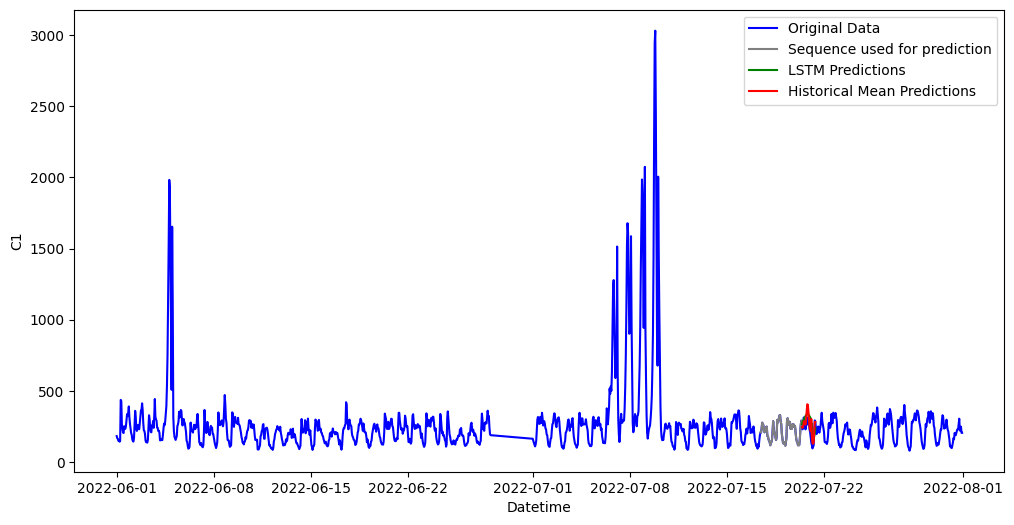

/tmp/ipykernel_58186/4117994613.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(datetimes[test_start - zoom_range], datetimes[test_start + FUTURE])


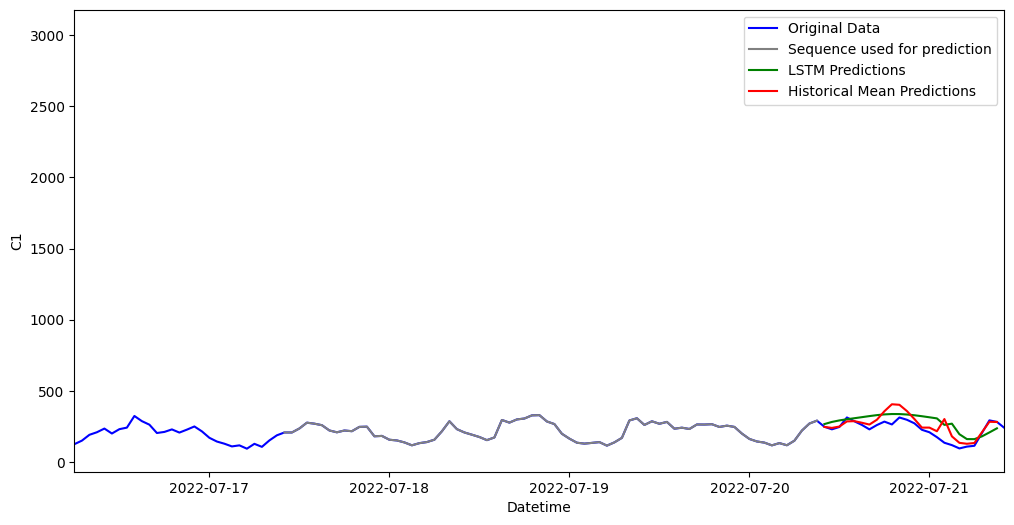

Epoch [100/100], Loss: 0.004491007421165705
Street: Ponte 25 Abril 102/103
LSTM Model - Average Mean Absolute Error (MAE): 19.32621434000459
LSTM Model - Average Root Mean Squared Error (RMSE): 26.65954922520595
Historical Mean Model - Average Mean Absolute Error (MAE): 14.103169528604916
Historical Mean Model - Average Root Mean Squared Error (RMSE): 23.669781453208916


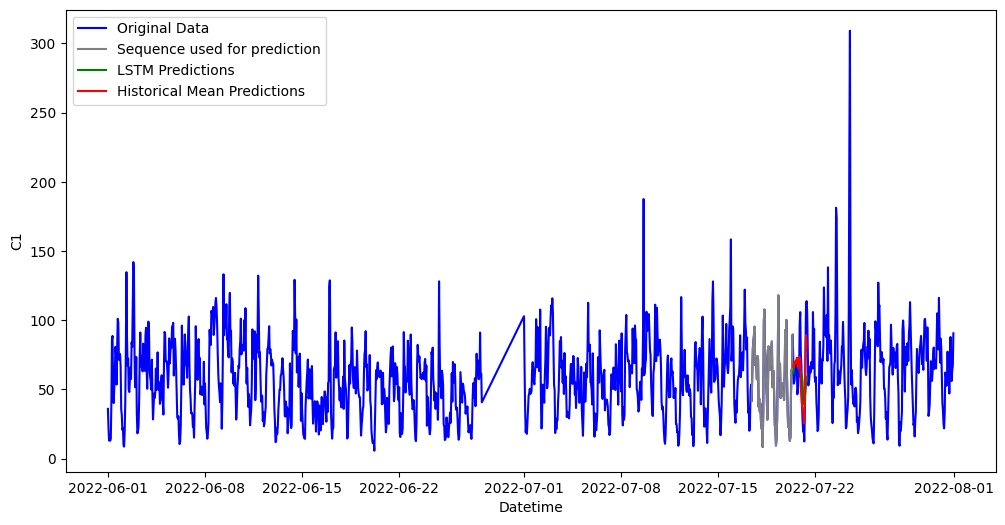

/tmp/ipykernel_58186/4117994613.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(datetimes[test_start - zoom_range], datetimes[test_start + FUTURE])


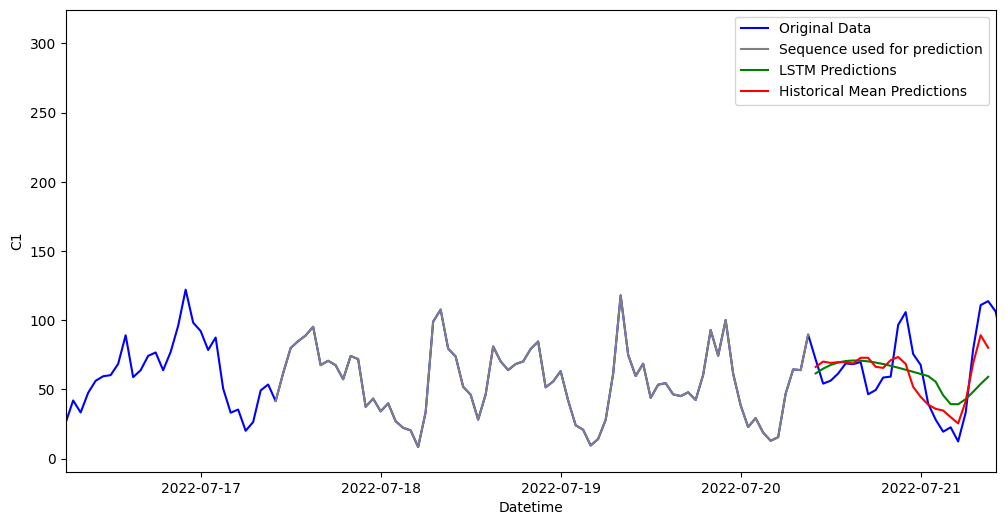

Epoch [100/100], Loss: 0.007472393102943897
Street: A5
LSTM Model - Average Mean Absolute Error (MAE): 23.87565777999076
LSTM Model - Average Root Mean Squared Error (RMSE): 29.068183828714236
Historical Mean Model - Average Mean Absolute Error (MAE): 24.219109220620332
Historical Mean Model - Average Root Mean Squared Error (RMSE): 30.181494912084315


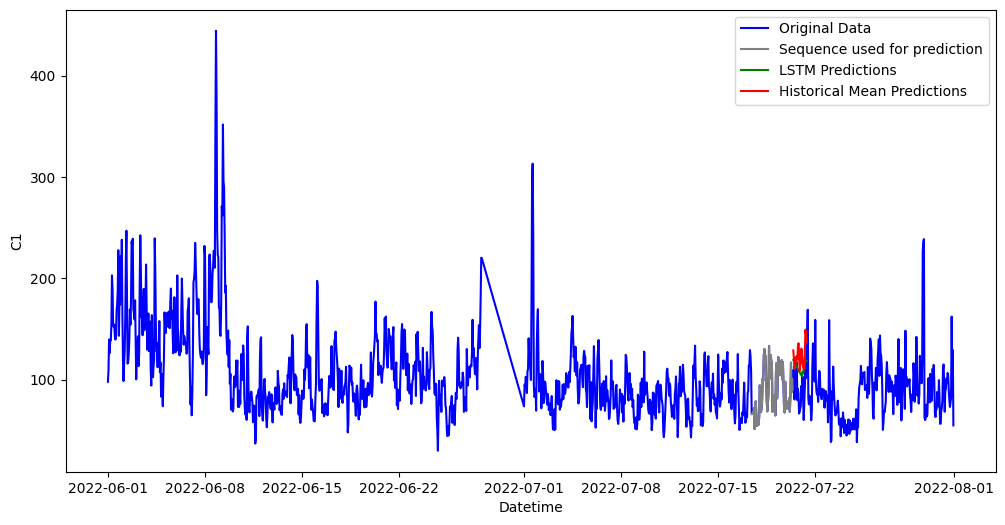

/tmp/ipykernel_58186/4117994613.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(datetimes[test_start - zoom_range], datetimes[test_start + FUTURE])


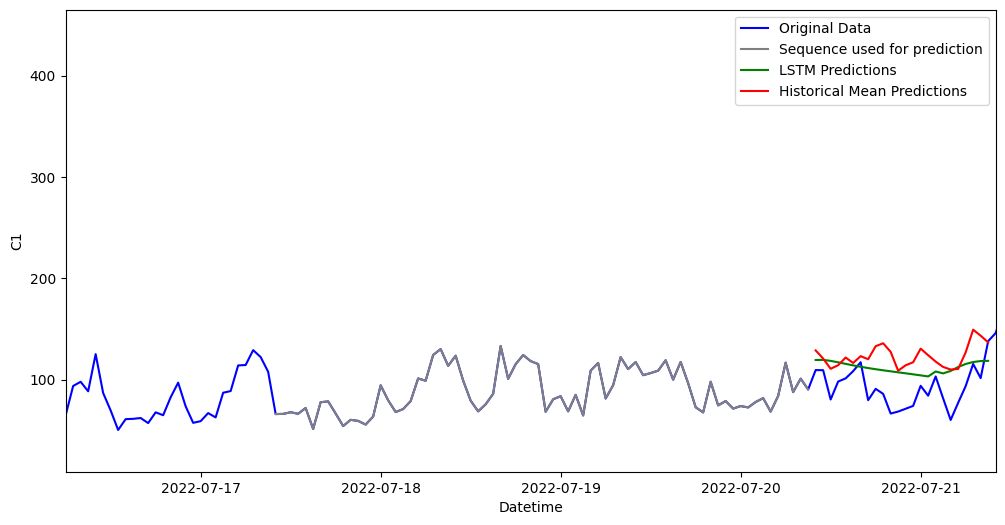

Epoch [100/100], Loss: 0.0222854595631361
Street: N117
LSTM Model - Average Mean Absolute Error (MAE): 25.99350101926125
LSTM Model - Average Root Mean Squared Error (RMSE): 29.77199673397035
Historical Mean Model - Average Mean Absolute Error (MAE): 18.038686568755615
Historical Mean Model - Average Root Mean Squared Error (RMSE): 22.726905938888017


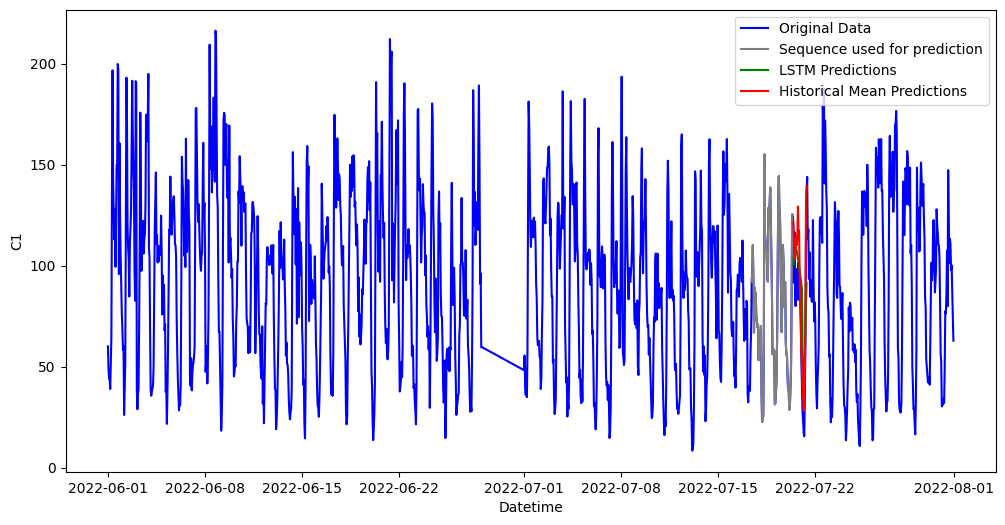

/tmp/ipykernel_58186/4117994613.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(datetimes[test_start - zoom_range], datetimes[test_start + FUTURE])


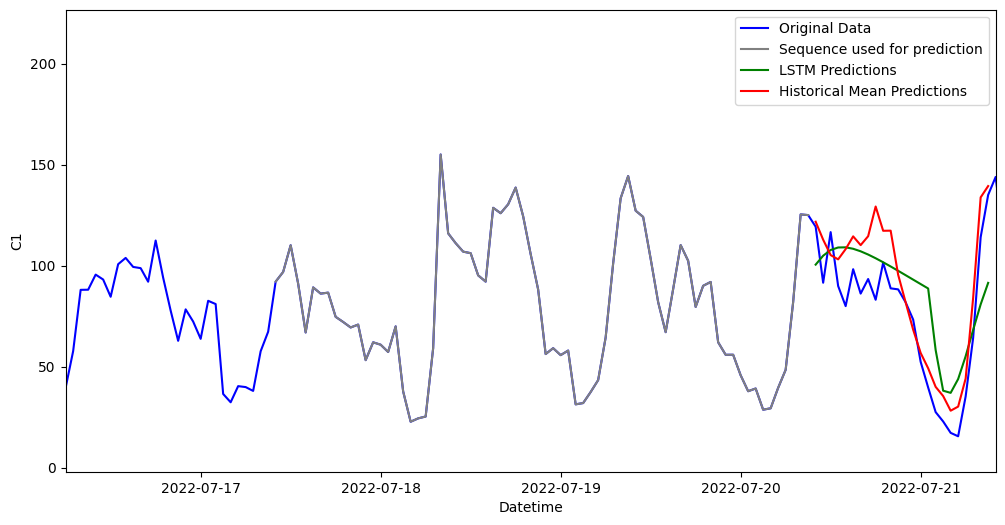

Epoch [100/100], Loss: 0.016980698332190514
Street: IC19
LSTM Model - Average Mean Absolute Error (MAE): 29.13469239234621
LSTM Model - Average Root Mean Squared Error (RMSE): 35.3733546918429
Historical Mean Model - Average Mean Absolute Error (MAE): 20.515499629006264
Historical Mean Model - Average Root Mean Squared Error (RMSE): 26.598896378058058


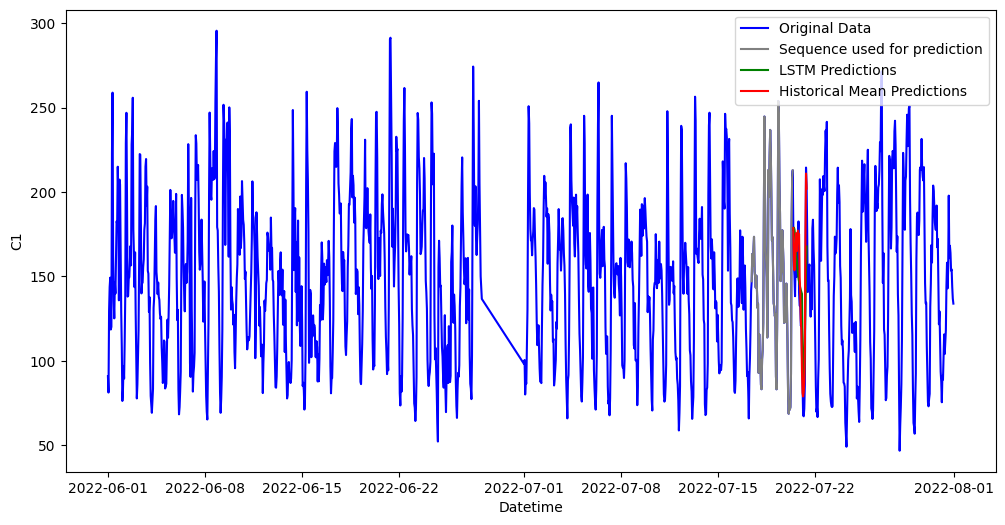

/tmp/ipykernel_58186/4117994613.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(datetimes[test_start - zoom_range], datetimes[test_start + FUTURE])


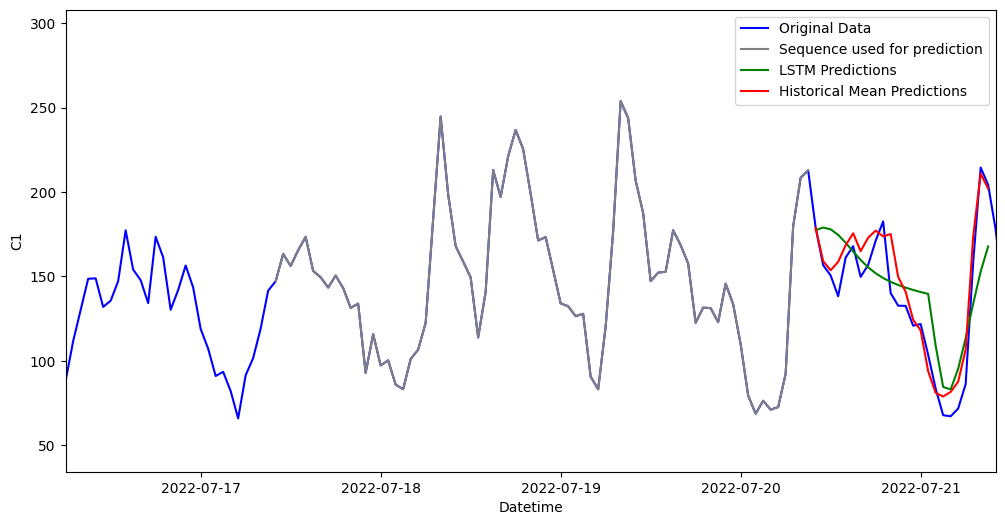

Epoch [100/100], Loss: 0.005821462720632553
Street: A16
LSTM Model - Average Mean Absolute Error (MAE): 9.11912236423971
LSTM Model - Average Root Mean Squared Error (RMSE): 11.87422273411796
Historical Mean Model - Average Mean Absolute Error (MAE): 7.333277727821723
Historical Mean Model - Average Root Mean Squared Error (RMSE): 9.59918098485292


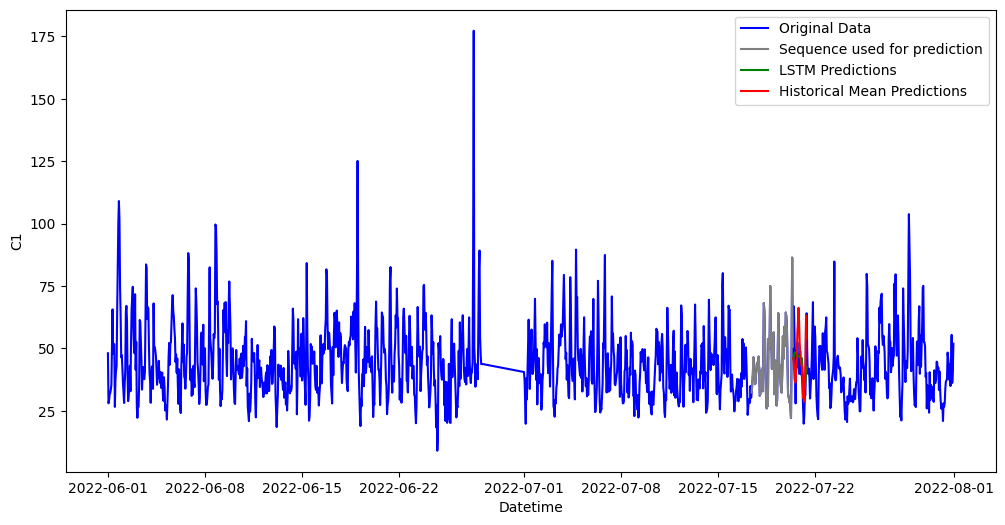

/tmp/ipykernel_58186/4117994613.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(datetimes[test_start - zoom_range], datetimes[test_start + FUTURE])


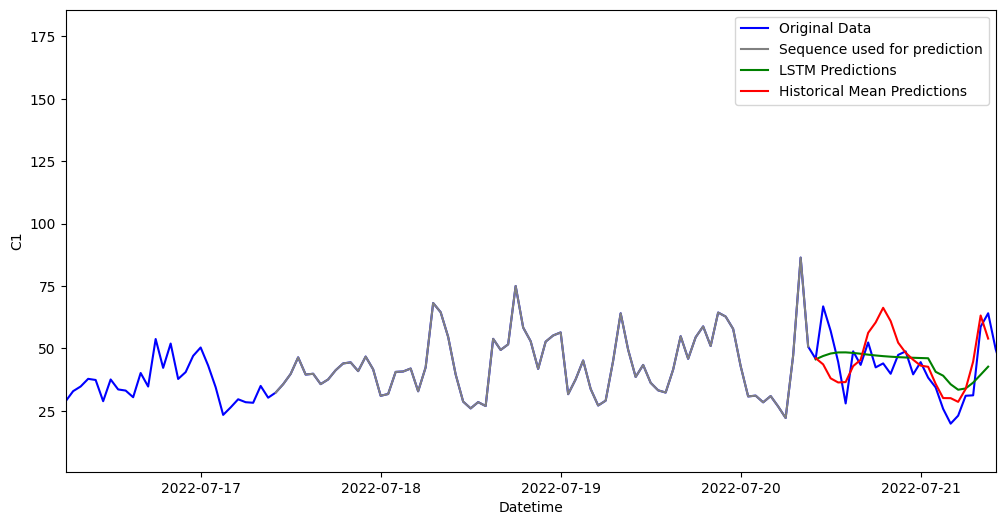

Epoch [100/100], Loss: 0.018539439886808395
Street: Calcada De Carriche
LSTM Model - Average Mean Absolute Error (MAE): 33.75748666059397
LSTM Model - Average Root Mean Squared Error (RMSE): 40.214804289731745
Historical Mean Model - Average Mean Absolute Error (MAE): 26.134821986341382
Historical Mean Model - Average Root Mean Squared Error (RMSE): 32.396926785369395


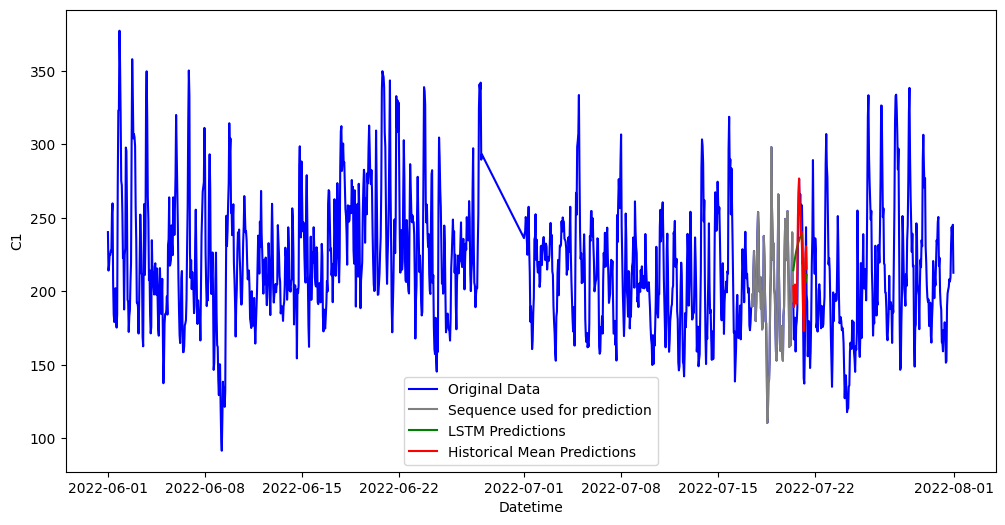

/tmp/ipykernel_58186/4117994613.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(datetimes[test_start - zoom_range], datetimes[test_start + FUTURE])


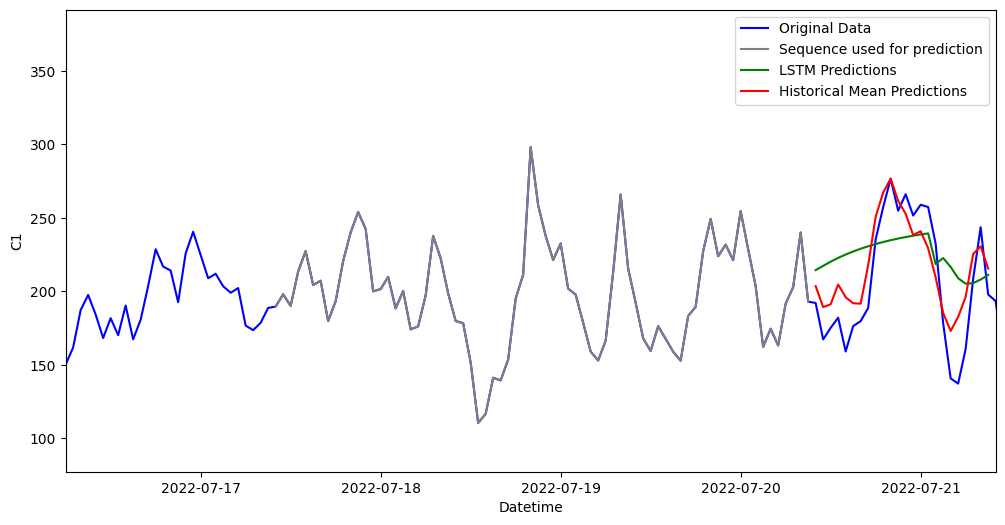

Epoch [100/100], Loss: 0.008928775787353516
Street: A1
LSTM Model - Average Mean Absolute Error (MAE): 29.0931211973086
LSTM Model - Average Root Mean Squared Error (RMSE): 37.939209573588585
Historical Mean Model - Average Mean Absolute Error (MAE): 25.888953284296463
Historical Mean Model - Average Root Mean Squared Error (RMSE): 35.978201221081726


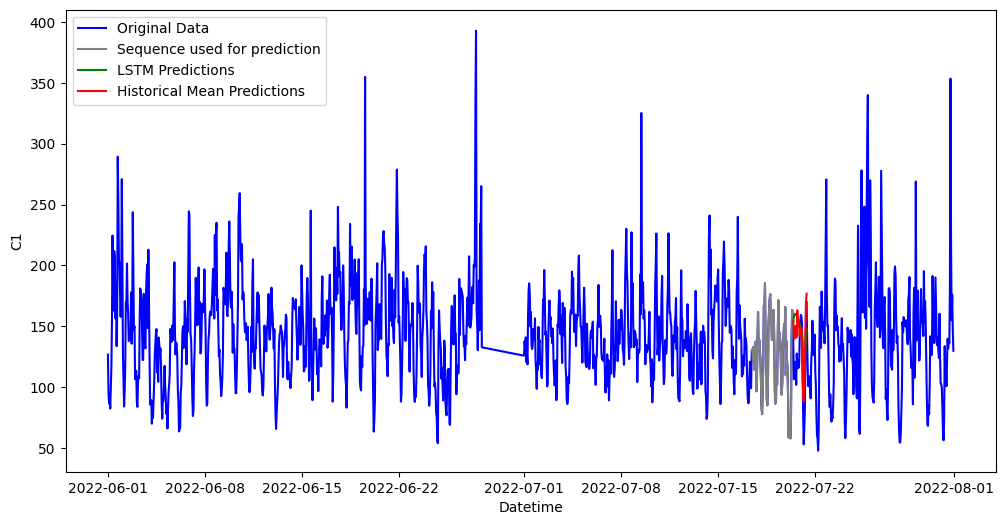

/tmp/ipykernel_58186/4117994613.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(datetimes[test_start - zoom_range], datetimes[test_start + FUTURE])


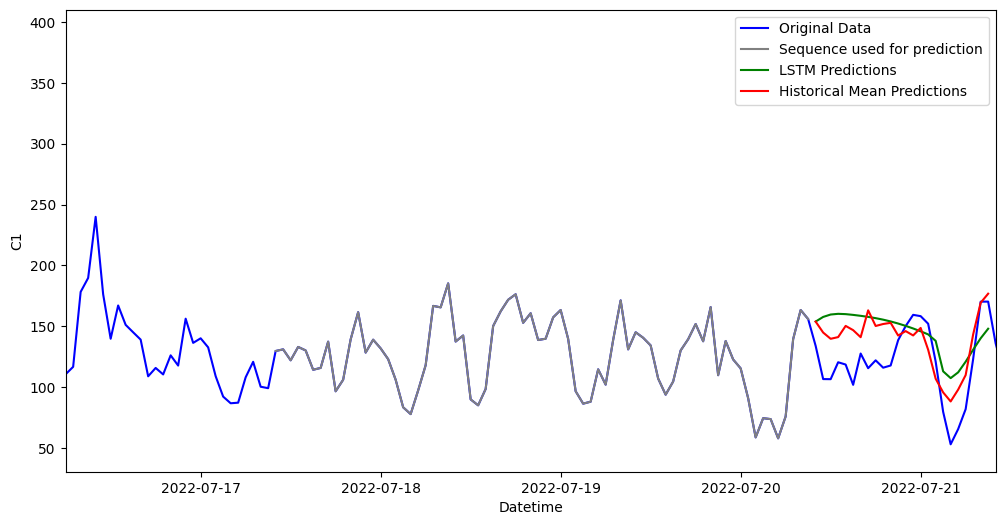

Epoch [100/100], Loss: 0.012913518585264683
Street: A36
LSTM Model - Average Mean Absolute Error (MAE): 20.93375068184585
LSTM Model - Average Root Mean Squared Error (RMSE): 26.15428716534267
Historical Mean Model - Average Mean Absolute Error (MAE): 14.831321485468129
Historical Mean Model - Average Root Mean Squared Error (RMSE): 20.411562658052986


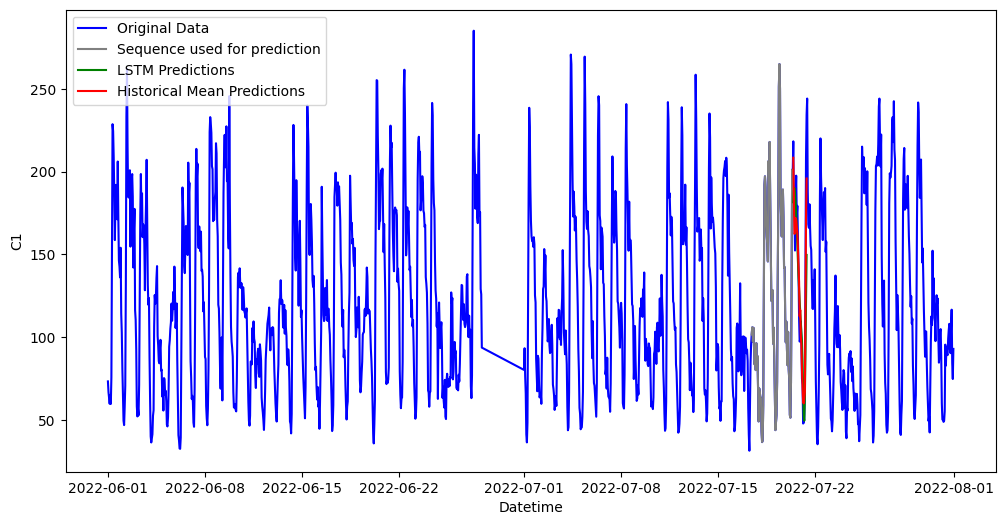

/tmp/ipykernel_58186/4117994613.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(datetimes[test_start - zoom_range], datetimes[test_start + FUTURE])


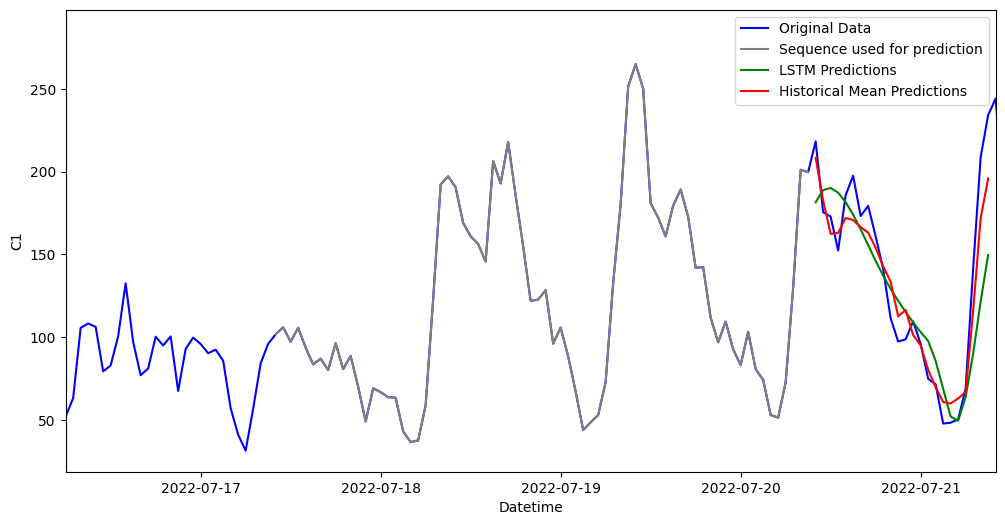

Epoch [100/100], Loss: 0.0044277869164943695
Street: Ponte Vasco da Gama
LSTM Model - Average Mean Absolute Error (MAE): 12.743478716524349
LSTM Model - Average Root Mean Squared Error (RMSE): 14.496077045636698
Historical Mean Model - Average Mean Absolute Error (MAE): 12.198174305813628
Historical Mean Model - Average Root Mean Squared Error (RMSE): 14.747886816373692


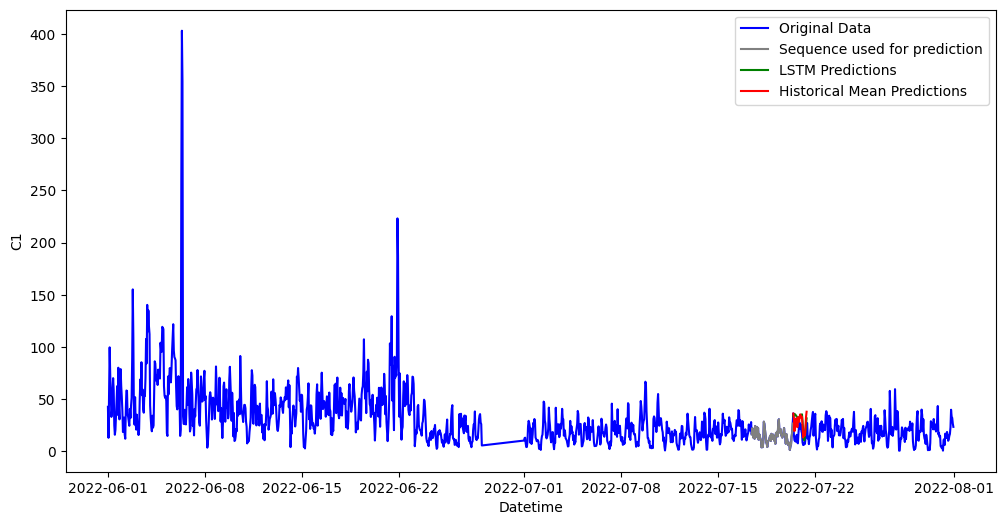

/tmp/ipykernel_58186/4117994613.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(datetimes[test_start - zoom_range], datetimes[test_start + FUTURE])


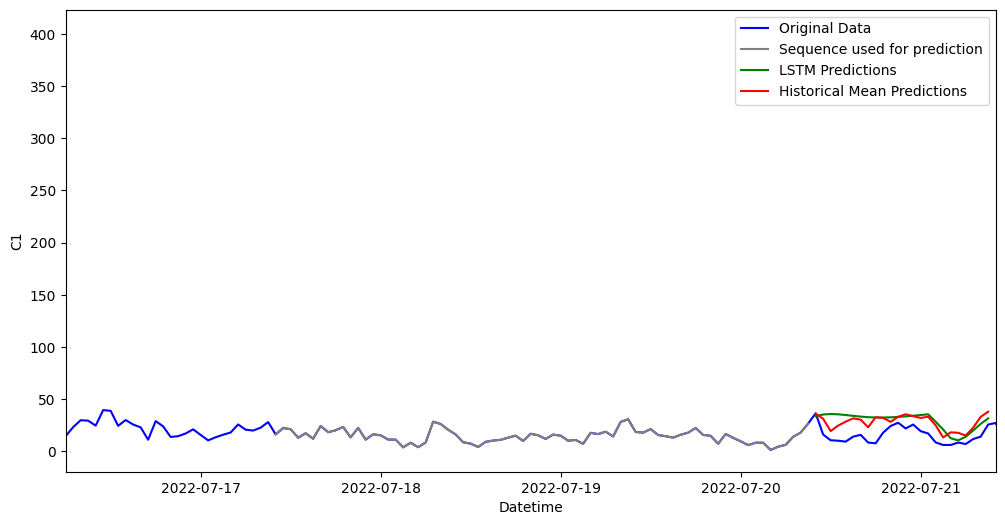

Epoch [100/100], Loss: 0.01702515408396721
Street: IC16
LSTM Model - Average Mean Absolute Error (MAE): 21.390021757352738
LSTM Model - Average Root Mean Squared Error (RMSE): 26.611222336593574
Historical Mean Model - Average Mean Absolute Error (MAE): 17.188890187364635
Historical Mean Model - Average Root Mean Squared Error (RMSE): 21.66965221517034


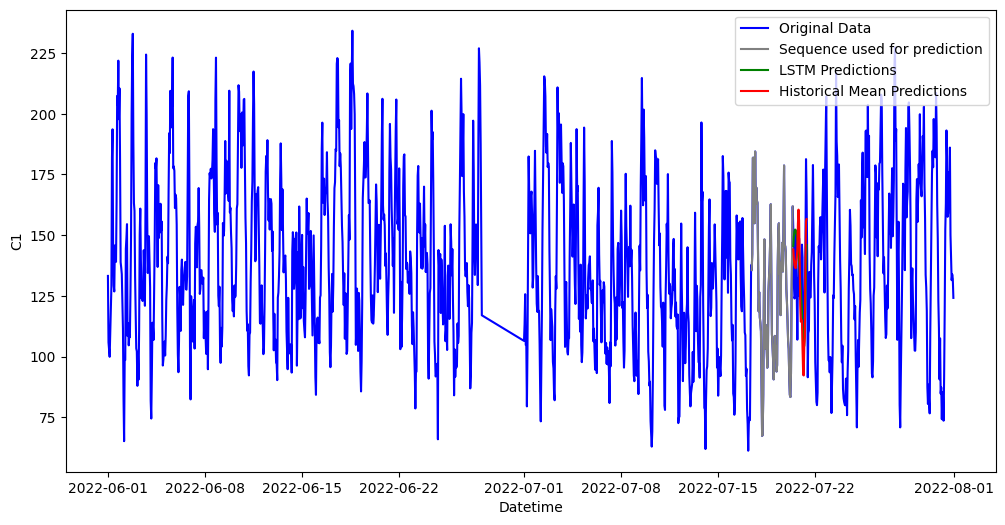

/tmp/ipykernel_58186/4117994613.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(datetimes[test_start - zoom_range], datetimes[test_start + FUTURE])


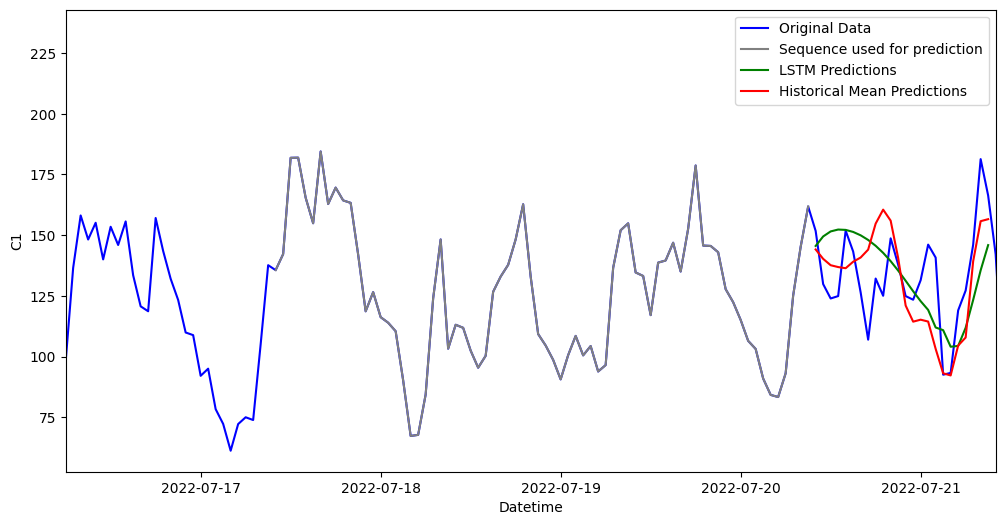

Epoch [100/100], Loss: 0.01495066937059164
Street: IC2 (Sacavém)
LSTM Model - Average Mean Absolute Error (MAE): 14.049351973749376
LSTM Model - Average Root Mean Squared Error (RMSE): 17.0075456105391
Historical Mean Model - Average Mean Absolute Error (MAE): 11.22183947055347
Historical Mean Model - Average Root Mean Squared Error (RMSE): 14.169015173440965


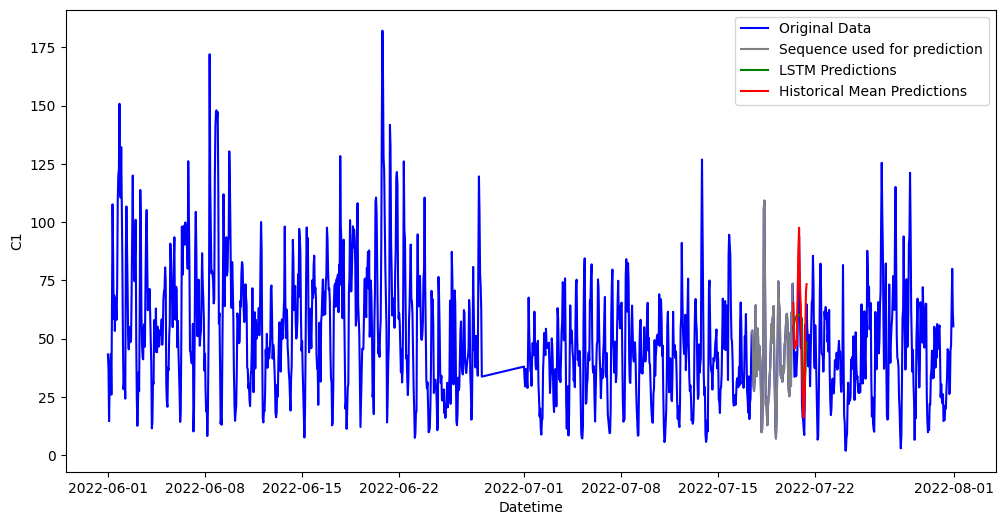

/tmp/ipykernel_58186/4117994613.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(datetimes[test_start - zoom_range], datetimes[test_start + FUTURE])


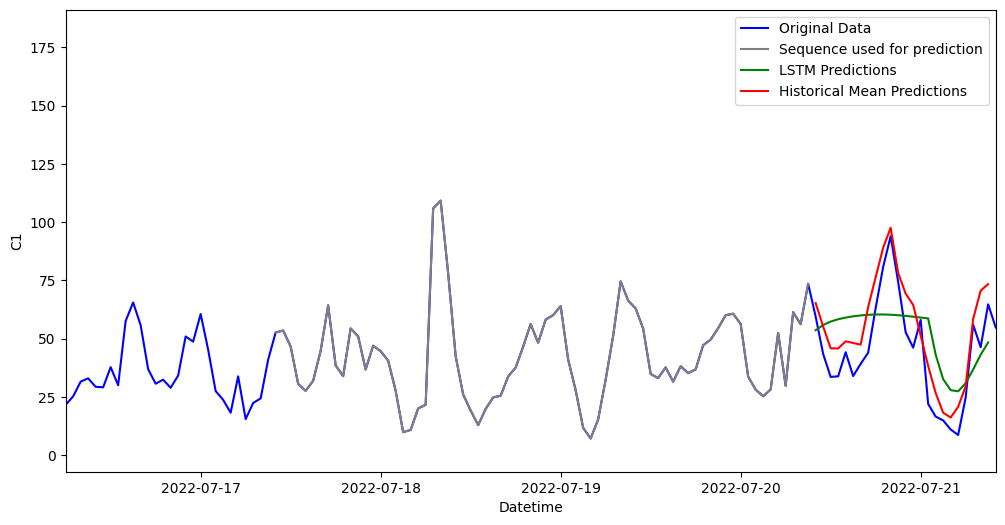

Average LSTM Mean Absolute Error (MAE): 26.866259932261826
Average LSTM Root Mean Squared Error (RMSE): 33.278864745261735
Average Historical Mean Mean Absolute Error (MAE): 21.340907898650936
Average Historical Mean Root Mean Squared Error (RMSE): 29.91428741465455


In [16]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define model parameters
INPUT_SIZE = 3
HIDDEN_SIZE = 30
OUTPUT_SIZE = 1  # Predicting one value (C1)
SEQUENCE_LENGTH = 72
NUM_EPOCHS = 1500
LEARNING_RATE = 0.001
TEST_SIZE = 0.2
RANDOM_STATE = 42
FUTURE = 24



class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


def calculate_historical_mean(df):
    # Group by DayOfWeek and Hour, and calculate the mean of C1
    historical_mean = df.groupby(['DayOfWeek', 'Hour'])['C1'].mean()

    # Map the historical mean to the corresponding DayOfWeek and Hour
    df['HistoricalMean'] = df.apply(lambda row: historical_mean[row['DayOfWeek'], row['Hour']], axis=1)

    return df


def evaluate_historical_mean_model(df, test_size):
    # Split the data into training and test sets
    train_size = int(len(df) * (1 - test_size))
    train_df = df[:train_size]
    test_df = df[train_size:]

    # The predictions of the historical mean model are simply the 'HistoricalMean' column
    predictions = test_df['HistoricalMean'].values

    # The true values are the 'C1' column
    true_values = test_df['C1'].values

    # Calculate the MAE and RMSE
    mae = mean_absolute_error(true_values, predictions)
    rmse = np.sqrt(mean_squared_error(true_values, predictions))

    return mae, rmse

def create_sequences(data, day_of_week, hour, seq_length):
    sequences = []
    labels = []

    for i in range(len(data) - seq_length):
        seq = torch.cat([data[i:i+seq_length], day_of_week[i:i+seq_length], hour[i:i+seq_length]], dim=1)
        label = data[i+seq_length:i+seq_length+1]
        sequences.append(seq)
        labels.append(label)

    return torch.stack(sequences), torch.stack(labels)

def preprocess_data(df):


    # Resample the "C1" column for each hour and calculate the mean values
    df_hourly_mean = df["C1"].resample("H").mean().interpolate()    

    # Create a new DataFrame with the mean values, Grid_ID, and Datetime
    resampled_df = pd.DataFrame({
        "Grid_ID": df["Grid_ID"].resample("H").first(),
        "Datetime": df_hourly_mean.index,
        "C1": df_hourly_mean
    })

    resampled_df["DayOfWeek"] = resampled_df["Datetime"].dt.dayofweek
    resampled_df["Hour"] = resampled_df["Datetime"].dt.hour

    day_of_week_values = resampled_df["DayOfWeek"].values
    day_of_week_tensor = torch.tensor(day_of_week_values, dtype=torch.float32).reshape(-1, 1)
    hour_values = resampled_df["Hour"].values
    hour_tensor = torch.tensor(hour_values, dtype=torch.float32).reshape(-1, 1)
    resampled_df = calculate_historical_mean(resampled_df)

    target_col = 'C1'
    target = resampled_df[target_col].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    target_scaled = scaler.fit_transform(target)
    target_tensor = torch.tensor(target_scaled, dtype=torch.float32)


    # Define sequence length and create sequences
    sequences, labels = create_sequences(target_tensor, day_of_week_tensor, hour_tensor, SEQUENCE_LENGTH)
    X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=False)

    return X_train, X_test, y_train, y_test, target, scaler, resampled_df


def train_model(X_train, y_train):
    model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(NUM_EPOCHS):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)

        loss = criterion(outputs.squeeze(), y_train.squeeze()) 
        loss.backward()
        optimizer.step()

        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item()}')

    return model

def evaluate_model(model, X_test, y_test, scaler):
    # Your evaluation code here
    model.eval()
    num_test_sequences = len(X_test) - FUTURE
    test_sequences = X_test[:num_test_sequences, :, :]
    predicted_sequences = []
    with torch.no_grad():
        for test_seq in test_sequences:
            base_seq = test_seq.unsqueeze(0).clone()
            predicted_seq = []
            next_day = base_seq[:, -1:, 1]
            for i in range(FUTURE):
                pred = model(base_seq)
                predicted_seq.append(pred.item())

                next_hour = (base_seq[:, -1:, 2] + 1) % 24
                if(next_hour == 0):
                    next_day = (base_seq[:, -1:, 1] + 1) % 7
            
                next_value = torch.cat([pred.unsqueeze(2), next_day.unsqueeze(2), next_hour.unsqueeze(2)], dim=2)  # Include hour tensor
                base_seq = torch.cat([base_seq[:, 1:, :], next_value], dim=1)
            # Inverse transform the values
            predicted_seq = np.array(predicted_seq).reshape(-1, 1)
            predicted_seq = scaler.inverse_transform(predicted_seq)
            predicted_sequences.append(predicted_seq)


    y_test = scaler.inverse_transform(y_test.squeeze().reshape(-1, 1))
    mae_list = []
    rmse_list = []

    for i in range(num_test_sequences):
        y_t = y_test[i:i+FUTURE]
        predicted_seq = predicted_sequences[i]
        mae = mean_absolute_error(y_t, predicted_seq)
        rmse = np.sqrt(mean_squared_error(y_t, predicted_seq))

        mae_list.append(mae)
        rmse_list.append(rmse)

    average_mae = np.mean(mae_list)
    average_rmse = np.mean(rmse_list)

    
    return predicted_sequences, test_sequences, average_mae, average_rmse

def plot_results(target, y_test, predicted_sequences, seq_used_pred, historical_mean_predictions, datetimes, test_start):

    plt.figure(figsize=(12, 6))
    plt.plot(datetimes, target, label='Original Data', color='blue')
    plt.plot(datetimes[test_start - len(seq_used_pred):test_start],  np.array(seq_used_pred).reshape(-1, 1), label='Sequence used for prediction', color='gray')
    plt.plot(datetimes[test_start:test_start + FUTURE], predicted_sequences[0], label='LSTM Predictions', color='green')
    plt.plot(datetimes[test_start:test_start + FUTURE], historical_mean_predictions, label='Historical Mean Predictions', color='red')

    plt.xlabel('Datetime')
    plt.ylabel("C1")
    plt.legend()
    plt.show()

def plot_zoomed(target, y_test, predicted_sequences, seq_used_pred, historical_mean_predictions, datetimes, test_start, zoom_range=100):
    test_start = len(target) - len(y_test) +1

    plt.figure(figsize=(12, 6))
    plt.plot(datetimes, target, label='Original Data', color='blue')
    plt.plot(datetimes[test_start - len(seq_used_pred):test_start],  np.array(seq_used_pred).reshape(-1, 1), label='Sequence used for prediction', color='gray')
    plt.plot(datetimes[test_start:test_start + FUTURE], predicted_sequences[0], label='LSTM Predictions', color='green')
    plt.plot(datetimes[test_start:test_start + FUTURE], historical_mean_predictions, label='Historical Mean Predictions', color='red')

    # Zoom in on a smaller period of time
    plt.xlim(datetimes[test_start - zoom_range], datetimes[test_start + FUTURE])

    plt.xlabel('Datetime')
    plt.ylabel("C1")
    plt.legend()
    plt.show()

def main():
    # df = pd.read_csv("data/reduced/June2022_reduced.csv")
    hist_mae_list = []
    hist_rmse_list = []
    lstm_mae_list = []
    lstm_rmse_list = []
    for ax, street_name in zip(axes.flatten(), street_names):
        street_df = entrance_roads_df[entrance_roads_df['street_name'] == street_name].copy()
        street_df.set_index('Datetime', inplace=True)
        X_train, X_test, y_train, y_test, target, scaler, resampled_df = preprocess_data(street_df)
        datetimes = resampled_df["Datetime"]
        model = train_model(X_train, y_train)
        predicted_sequences, test_sequences, average_mae, average_rmse = evaluate_model(model, X_test, y_test, scaler)
        print(f"Street: {street_name}")
        print(f"LSTM Model - Average Mean Absolute Error (MAE): {average_mae}")
        print(f"LSTM Model - Average Root Mean Squared Error (RMSE): {average_rmse}")
        lstm_mae_list.append(average_mae)
        lstm_rmse_list.append(average_rmse)

        # Evaluate the historical mean model
        historical_mean_mae, historical_mean_rmse = evaluate_historical_mean_model(resampled_df, TEST_SIZE)
        print(f"Historical Mean Model - Average Mean Absolute Error (MAE): {historical_mean_mae}")
        print(f"Historical Mean Model - Average Root Mean Squared Error (RMSE): {historical_mean_rmse}")
        hist_mae_list.append(historical_mean_mae)
        hist_rmse_list.append(historical_mean_rmse) 

        # Get the historical mean predictions
        test_start = len(target) - len(y_test) +1
        historical_mean_predictions = resampled_df['HistoricalMean'].values[test_start:test_start + FUTURE]

        seq_used_pred = scaler.inverse_transform(test_sequences[1, :,0].squeeze().reshape(-1, 1).clone())
        plot_results(target, y_test, predicted_sequences, seq_used_pred, historical_mean_predictions, datetimes, test_start)
        plot_zoomed(target, y_test, predicted_sequences, seq_used_pred, historical_mean_predictions, datetimes, test_start)

    print(f"Average LSTM Mean Absolute Error (MAE): {np.mean(lstm_mae_list)}")
    print(f"Average LSTM Root Mean Squared Error (RMSE): {np.mean(lstm_rmse_list)}")
    print(f"Average Historical Mean Mean Absolute Error (MAE): {np.mean(hist_mae_list)}")
    print(f"Average Historical Mean Root Mean Squared Error (RMSE): {np.mean(hist_rmse_list)}")   
        
if __name__ == "__main__":
    main()

### Experimenting with LSTM model

Several experiments were conducted to evaluate the performance of an LSTM model in predicting time series data. The LSTM model was employed to predict consecutive values of the C1 parameter, representing the number of distinct terminals in the grid. To clean the dataset, irrelevant columns were removed, and a specific grid (number 16) was chosen for experimentation. The C1 parameter was resampled to reflect the mean traffic in each hour and interpolated to address missing values.

Data transformation involved organizing it into sequences and labels suitable for LSTM training. Each sequence comprised 80 values, predicting one value. Subsequently, all sequences were divided into training and testing sets. The model underwent training and evaluation, wherein 100 consecutive values were predicted from a sequence in the test set to assess model performance.

The results are depicted in a line plot, illustrating the predicted values, original data, and the sequence used for prediction. Plot presents period of one month, with time step equal one hour. This plot aids in gauging the accuracy of LSTM predictions. Observably, there is room for potential enhancement, suggesting avenues for improvement. For instance, incorporating additional parameters for prediction, such as the day of the week or hour, could refine the model's performance. Tweaking the hyperparameters and trying with more data might make the results better. We'll give it a shot in the next steps. 


